Source of code https://github.com/klemag/pydata_nyc2018-intro-to-model-interpretability.

In [1]:
# Setup
!pip install lime scikit-image xgboost keras tensorflow --upgrade
!pip install scikit-learn==0.20
!pip install shap

# Download files
!rm -f helpers.py*
!rm -f bank-additional-full.csv*
!wget https://github.com/klemag/pydata_nyc2018-intro-to-model-interpretability/raw/master/data/bank-additional/bank-additional-full.csv
!wget https://statelineah.com/wp-content/uploads/2018/02/smiling-pug.png
!wget https://raw.githubusercontent.com/klemag/pydata_nyc2018-intro-to-model-interpretability/master/helpers.py

Requirement already up-to-date: lime in /Users/orianaoniciuc/anaconda3/lib/python3.7/site-packages (0.1.1.37)
Requirement already up-to-date: scikit-image in /Users/orianaoniciuc/anaconda3/lib/python3.7/site-packages (0.16.2)
Requirement already up-to-date: xgboost in /Users/orianaoniciuc/anaconda3/lib/python3.7/site-packages (0.90)
Requirement already up-to-date: keras in /Users/orianaoniciuc/anaconda3/lib/python3.7/site-packages (2.3.1)
Requirement already up-to-date: tensorflow in /Users/orianaoniciuc/anaconda3/lib/python3.7/site-packages (2.1.0)


--2020-02-14 17:10:03--  https://github.com/klemag/pydata_nyc2018-intro-to-model-interpretability/raw/master/data/bank-additional/bank-additional-full.csv
Resolving github.com (github.com)... 140.82.118.3
Connecting to github.com (github.com)|140.82.118.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/klemag/pydata_nyc2018-intro-to-model-interpretability/master/data/bank-additional/bank-additional-full.csv [following]
--2020-02-14 17:10:04--  https://raw.githubusercontent.com/klemag/pydata_nyc2018-intro-to-model-interpretability/master/data/bank-additional/bank-additional-full.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 199.232.16.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|199.232.16.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5834924 (5.6M) [text/plain]
Saving to: ‘bank-additional-full.csv’

bank-additional-ful 100%[===============

# Introduction to Model Interpretability

Note: This notebook uses features introduced in Python 3.6 and sklearn 0.20.


First we'll need a few imports:

In [2]:
# Obviously
import pandas as pd

# Some sklearn tools for preprocessing and building a pipeline. 
# ColumnTransformer was introduced in 0.20 so make sure you have this version
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report

# Our algorithms, by from the easiest to the hardest to intepret.
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost.sklearn import XGBClassifier

### The Dataset

The dataset can be downloaded [here](https://archive.ics.uci.edu/ml/datasets/bank+marketing). It consists of data from marketing campaigns of a Portuguese bank. We will try to build classifiers that can predict whether or not the client targeted by the campaign ended up subscribing to a term deposit (column `y`).

In [3]:
df = pd.read_csv("bank-additional-full.csv", sep=";")

In [4]:
df.head()

age        job  marital    education  default housing loan    contact  \
0   56  housemaid  married     basic.4y       no      no   no  telephone   
1   57   services  married  high.school  unknown      no   no  telephone   
2   37   services  married  high.school       no     yes   no  telephone   
3   40     admin.  married     basic.6y       no      no   no  telephone   
4   56   services  married  high.school       no      no  yes  telephone   

  month day_of_week  ...  campaign  pdays  previous     poutcome emp.var.rate  \
0   may         mon  ...         1    999         0  nonexistent          1.1   
1   may         mon  ...         1    999         0  nonexistent          1.1   
2   may         mon  ...         1    999         0  nonexistent          1.1   
3   may         mon  ...         1    999         0  nonexistent          1.1   
4   may         mon  ...         1    999         0  nonexistent          1.1   

   cons.price.idx  cons.conf.idx  euribor3m  nr.employed   y  
0          93.994          -36.4      4.857       5191.0  no  
1          93.994          -36.4      4.857       5191.0  no  
2          93.994          -36.4      4.857       5191.0  no  
3          93.994          -36.4      4.857       5191.0  no  
4          93.994          -36.4      4.857       5191.0  no  

[5 rows x 21 columns]

In [5]:
df.y.value_counts()

no     36548
yes     4640
Name: y, dtype: int64

The dataset is imbalanced, we will need to keep that in mind when building our models!

In [6]:
# Get X, y
y = df["y"].map({"no":0, "yes":1})
X = df.drop("y", axis=1)

Let's look at the features in the X matrix:

1. age (numeric)
2. job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3. marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4. education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5. default: has credit in default? (categorical: 'no','yes','unknown')
6. housing: has housing loan? (categorical: 'no','yes','unknown')
7. loan: has personal loan? (categorical: 'no','yes','unknown')
8. contact: contact communication type (categorical: 'cellular','telephone') 
9. month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10. day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11. duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
12. campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13. pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14. previous: number of contacts performed before this campaign and for this client (numeric)
15. poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')

Data about bank:

16. emp.var.rate: employment variation rate - quarterly indicator (numeric)
17. cons.price.idx: consumer price index - monthly indicator (numeric) 
18. cons.conf.idx: consumer confidence index - monthly indicator (numeric) 
19. euribor3m: euribor 3 month rate - daily indicator (numeric)
20. nr.employed: number of employees - quarterly indicator (numeric)

Note the comment about `duration` feature. We will exclude it from our analysis.

In [7]:
X.drop("duration", inplace=True, axis=1)

In [8]:
X.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
dtype: object

In [9]:
# Some such as default would be binary features, but since
# they have a third class "unknown" we'll process them as non binary categorical
num_features = ["age", "campaign", "pdays", "previous", "emp.var.rate", 
                "cons.price.idx", "cons.conf.idx","euribor3m", "nr.employed"]

cat_features = ["job", "marital", "education","default", "housing", "loan",
                "contact", "month", "day_of_week", "poutcome"]

We'll define a new `ColumnTransformer` object that keeps our numerical features and apply one hot encoding on our categorical features. That will allow us to create a clean pipeline that includes both features engineering (one hot encoding here) and training the model (a nice way to avoid data leakage)

In [10]:
preprocessor = ColumnTransformer([("numerical", "passthrough", num_features), 
                                  ("categorical", OneHotEncoder(sparse=False, handle_unknown="ignore"),
                                   cat_features)])

Now we can define our 2 models as sklearn `Pipeline` object, containing our preprocessing step and training of one given algorithm.

In [11]:
# Random Forest
rf_model = Pipeline([("preprocessor", preprocessor), 
                     ("model", RandomForestClassifier(class_weight="balanced", n_estimators=100, n_jobs=-1))])

# XGBoost
xgb_model = Pipeline([("preprocessor", preprocessor), 
                      ("model", XGBClassifier(scale_pos_weight=(1 - y.mean()), n_jobs=-1))])

Let's split the data into training and test sets.

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.3, random_state=42)

We're good to go!

## LIME to generate local intepretations of black box models

LIME stands for `Local Interpretable Model-Agnostic Explanations`. We can use it with any model we've built in order to explain why it took a specific decision for a given observation. To do so, LIME creates a dataset in the locality of our observation by perturbating the different features. Then it fits a local linear model on this data and uses the weights on each feature to provide an explanation.

### with a Random Forest

In [13]:
gs = GridSearchCV(rf_model, {"model__max_depth": [10, 15], 
                             "model__min_samples_split": [5, 10]}, 
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...ators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [10, 15], 'model__min_samples_split': [5, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Let's see our best parameters and score

In [14]:
print(gs.best_params_)
print(gs.best_score_)

{'model__max_depth': 15, 'model__min_samples_split': 5}
0.8750303492768201


In [15]:
rf_model.set_params(**gs.best_params_)

Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...ators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False))])

In [16]:
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

In [17]:
accuracy_score(y_test, y_pred)

0.8812009387391762

In [18]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.92      0.93     10965
           1       0.48      0.57      0.52      1392

   micro avg       0.88      0.88      0.88     12357
   macro avg       0.71      0.75      0.73     12357
weighted avg       0.89      0.88      0.89     12357



Getting the column names after OneHotEncoder.

In [19]:
preprocessor = rf_model.named_steps["preprocessor"]
ohe_categories = preprocessor.named_transformers_["categorical"].categories_
new_ohe_features = [f"{col}__{val}" for col, vals in zip(cat_features, ohe_categories) for val in vals]
all_features = num_features + new_ohe_features
all_features

['age',
 'campaign',
 'pdays',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m',
 'nr.employed',
 'job__admin.',
 'job__blue-collar',
 'job__entrepreneur',
 'job__housemaid',
 'job__management',
 'job__retired',
 'job__self-employed',
 'job__services',
 'job__student',
 'job__technician',
 'job__unemployed',
 'job__unknown',
 'marital__divorced',
 'marital__married',
 'marital__single',
 'marital__unknown',
 'education__basic.4y',
 'education__basic.6y',
 'education__basic.9y',
 'education__high.school',
 'education__illiterate',
 'education__professional.course',
 'education__university.degree',
 'education__unknown',
 'default__no',
 'default__unknown',
 'default__yes',
 'housing__no',
 'housing__unknown',
 'housing__yes',
 'loan__no',
 'loan__unknown',
 'loan__yes',
 'contact__cellular',
 'contact__telephone',
 'month__apr',
 'month__aug',
 'month__dec',
 'month__jul',
 'month__jun',
 'month__mar',
 'month__may',
 'month__nov',
 'month__oct',
 'month__

Great, so now we have a nice list of columns after processing.

### Let's train our XGB model as well

In [20]:
gs = GridSearchCV(xgb_model, {"model__max_depth": [5, 10],
                              "model__min_child_weight": [5, 10],
                              "model__n_estimators": [25]},
                  n_jobs=-1, cv=5, scoring="accuracy")

gs.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...a=1, scale_pos_weight=0.8873458288821987, seed=None,
       silent=None, subsample=1, verbosity=1))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'model__max_depth': [5, 10], 'model__min_child_weight': [5, 10], 'model__n_estimators': [25]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

Let's see our best parameters and score.

In [21]:
print(gs.best_params_)
print(gs.best_score_)
xgb_model.set_params(**gs.best_params_)
xgb_model.fit(X_train, y_train)

{'model__max_depth': 5, 'model__min_child_weight': 5, 'model__n_estimators': 25}
0.9002115778155457


Pipeline(memory=None,
     steps=[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
         transformer_weights=None,
         transformers=[('numerical', 'passthrough', ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed'...a=1, scale_pos_weight=0.8873458288821987, seed=None,
       silent=None, subsample=1, verbosity=1))])

Generate predictions

In [22]:
y_pred = xgb_model.predict(X_test)

In [23]:
accuracy_score(y_test, y_pred)

0.9014323865015781

In [24]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95     10965
           1       0.71      0.21      0.32      1392

   micro avg       0.90      0.90      0.90     12357
   macro avg       0.81      0.60      0.64     12357
weighted avg       0.89      0.90      0.88     12357



### Create an explainer

In order to explain why the model classifies invidividual observations as class 0 or 1, we are going to use the `LimeTabularExplainer` from the library `lime`, this is the main explainer to use for tabular data. Lime also provides an explainer for text data, for images and for time-series.

When using the tabular explainer, we need to provide our training set as parameter so that `lime` can compute statistics on each feature, either `mean` and `std` for numerical features, or frequency of values for categorical features. Those statistics are used to scale the data and generate new perturbated data to train our local linear models on.

In [25]:
from lime.lime_tabular import LimeTabularExplainer

The parameters passed to the explainer are:
- our training set, we need to make sure we use the training set *without* one hot encoding
- `mode`: the explainer can be used for classification or regression
- `feature_names`: list of labels for our features
- `categorical_features`: list of indexes of categorical features
- `categorical_names`: dict mapping each index of categorical feature to a list of corresponding labels
- `dicretize_continuous`: will discretize numerical values into buckets that can be used for explanation. For instance it can tell us that the decision was made because distance is in bucket [5km, 10km] instead of telling us distance is an importante feature.

First, in order to get the `categorical_names` parameter we need to build a dictionary with indexes of categorical values in original dataset as keys and lists of possible categories as values:

In [26]:
categorical_names = {}
for col in cat_features:
    categorical_names[X_train.columns.get_loc(col)] = [new_col.split("__")[1] 
                                                       for new_col in new_ohe_features 
                                                       if new_col.split("__")[0] == col]

In [27]:
categorical_names

{1: ['admin.',
  'blue-collar',
  'entrepreneur',
  'housemaid',
  'management',
  'retired',
  'self-employed',
  'services',
  'student',
  'technician',
  'unemployed',
  'unknown'],
 2: ['divorced', 'married', 'single', 'unknown'],
 3: ['basic.4y',
  'basic.6y',
  'basic.9y',
  'high.school',
  'illiterate',
  'professional.course',
  'university.degree',
  'unknown'],
 4: ['no', 'unknown', 'yes'],
 5: ['no', 'unknown', 'yes'],
 6: ['no', 'unknown', 'yes'],
 7: ['cellular', 'telephone'],
 8: ['apr', 'aug', 'dec', 'jul', 'jun', 'mar', 'may', 'nov', 'oct', 'sep'],
 9: ['fri', 'mon', 'thu', 'tue', 'wed'],
 13: ['failure', 'nonexistent', 'success']}

`Lime` needs the dataset that is passed to have categorical values converted to integer labels that maps to the values in `categorical_names`. For instance, label `0` for the column `2` will map to `divorced`. We will use a custom helper function to do so, that converts data from original to LIME and from LIME to original format.

That function is going over all categorical features and replacing strings by the correct integer labels, feel free to check `helpers.py`.

In [28]:
from helpers import convert_to_lime_format

Let's check that it worked:

In [29]:
convert_to_lime_format(X_train, categorical_names).head()

age  job  marital  education  default  housing  loan  contact  month  \
7309    50    1        2          0        0        0     0        1      6   
4169    51    7        1          5        1        0     0        1      6   
35810   46    9        0          5        0        2     0        0      6   
9668    46    0        2          6        0        2     0        1      4   
34389   25    7        2          3        0        0     0        0      6   

       day_of_week  campaign  pdays  previous  poutcome  emp.var.rate  \
7309             2         2    999         0         1           1.1   
4169             1         5    999         0         1           1.1   
35810            1         2    999         0         1          -1.8   
9668             1         1    999         0         1           1.4   
34389            2         5    999         0         1          -1.8   

       cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
7309           93.994          -36.4      4.860       5191.0  
4169           93.994          -36.4      4.858       5191.0  
35810          92.893          -46.2      1.244       5099.1  
9668           94.465          -41.8      4.961       5228.1  
34389          92.893          -46.2      1.266       5099.1

In [30]:
explainer = LimeTabularExplainer(convert_to_lime_format(X_train, categorical_names).values,
                                 mode="classification",
                                 feature_names=X_train.columns.tolist(),
                                 categorical_names=categorical_names,
                                 categorical_features=categorical_names.keys(),
                                 discretize_continuous=True,
                                 random_state=42)

Great, our explainer is ready. Now let's pick an observation we want to explain.

#### Explain new observations

We'll create a variable called `observation` that contains our ith observation in the test dataset.

In [31]:
i = 2
X_observation = X_test.iloc[[i], :]
X_observation

age         job marital            education default housing loan  \
12077   35  technician  single  professional.course      no      no   no   

         contact month day_of_week  campaign  pdays  previous     poutcome  \
12077  telephone   jun         fri         1    999         0  nonexistent   

       emp.var.rate  cons.price.idx  cons.conf.idx  euribor3m  nr.employed  
12077           1.4          94.465          -41.8      4.947       5228.1

In [32]:
print(f"""\
* True label: {y_test.iloc[i]}
* RF: {rf_model.predict_proba(X_observation)[0]}
* XGB: {xgb_model.predict_proba(X_observation)[0]}""")

* True label: 0
* RF: [0.84074105 0.15925895]
* XGB: [0.9292013  0.07079868]


Let's convert our observation to lime format and convert it to a numpy array.

In [33]:
observation = convert_to_lime_format(X_test.iloc[[i], :],categorical_names).values[0]
observation

array([ 3.5000e+01,  9.0000e+00,  2.0000e+00,  5.0000e+00,  0.0000e+00,
        0.0000e+00,  0.0000e+00,  1.0000e+00,  4.0000e+00,  0.0000e+00,
        1.0000e+00,  9.9900e+02,  0.0000e+00,  1.0000e+00,  1.4000e+00,
        9.4465e+01, -4.1800e+01,  4.9470e+00,  5.2281e+03])

In order to explain a prediction, we use the `explain_instance` method on our explainer. This will generate new data with perturbated features around the observation and learn a local linear model. It needs to take:
- our observation as a numpy array
- a function that uses our model to predict probabilities given the data (in same format we've passed in our explainer). That means we cannot pass directly our `rf_model.predict_proba` because our pipeline expects string labels for categorical values. We will need to create a custom function `rf_predict_proba` that first converts back integer labels to strings and then calls `rf_model.predict_proba`.
- `num_features`: number of features to consider in explanation

In [34]:
# Let write a custom predict_proba functions for our models:
from functools import partial

def custom_predict_proba(X, model):
    X_str = convert_to_lime_format(X, categorical_names, col_names=X_train.columns, invert=True)
    return model.predict_proba(X_str)

rf_predict_proba = partial(custom_predict_proba, model=rf_model)
xgb_predict_proba = partial(custom_predict_proba, model=xgb_model)

LIME is fitting a linear model on a local perturbated dataset. You can access the coefficients, the intercept and the R squared of the linear model by calling respectively `.local_exp`, `.intercept` and `.score` on your explanation.

If your R-squared is low, the linear model that LIME fitted isn't a great approximation to your model, which means you should not rely too much on the explanation it provides.

Now that we have generated our explanation, we have access to several representations. The most useful one when working in a notebook is `show_in_notebook`.


On the left it shows the list of probabilities for each class, here the model classified our observation as 0 (non subsribed) with a high probability.
* If you set `show_table=True`, you will see the table with the most important features for this observation on the right.

In [35]:
explanation = explainer.explain_instance(observation, rf_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.3771432907211112


In [36]:
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)

{1: [(7, -0.09114655080269676), (4, 0.07386679317698971), (14, -0.04991454290054551), (18, -0.046705070852772555), (17, -0.02162897894381914)]}
{1: 0.36377478156008064}
0.3771432907211112


In [37]:
explanation = explainer.explain_instance(observation, xgb_predict_proba, num_features=5)
explanation.show_in_notebook(show_table=True, show_all=False)
print(explanation.score)

0.23577354974758755


In [38]:
print(explanation.local_exp)
print(explanation.intercept)
print(explanation.score)

{1: [(18, -0.10456820567650713), (7, -0.05487352162677201), (17, -0.02179429164478311), (15, -0.010372574365263494), (16, -0.00875643298802108)]}
{1: 0.25814588184348364}
0.23577354974758755


## More local interpretation with SHAP

In [39]:
import shap
# Need to load JS vis in the notebook
shap.initjs() 

SHAP has a generic explainer that works for any model and a TreeExplainer optimised for tree based models. Here we will focus on the `TreeExplainer` with our XGB model (the hardest to intepret)

In [40]:
explainer = shap.TreeExplainer(xgb_model.named_steps["model"])

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In order to compute the shapley values with the tree explainer, we need to call the `shap_values` methods passing a dataset. That can be quite computationally expensive, so we will only pass 1000 samples picked at random.

In [41]:
observations = xgb_model.named_steps["preprocessor"].transform(X_train.sample(1000, random_state=42))
shap_values = explainer.shap_values(observations)

Now we can start visualising our explanations using the `force_plot` function from the shap package passing our first shap_value (we also need to pass `explainer.expected_value` which is the base value).

The scale represents the Shapley values, if it is negative we will predict 0, else we predict 1.

In [42]:
shap.initjs() 
i = 0
shap.force_plot(explainer.expected_value, shap_values[i], 
                features=observations[i], feature_names=all_features)

This explanation shows how each feature contributes to shifting the prediction from the base value to the output value of the model either by decreasing or increasing the probability of our class.

We can also visualise all points in our dataset at once with a given class by passing all explanations for that class to `force_plot`

In [43]:
shap.initjs() 
shap.force_plot(explainer.expected_value, shap_values,
                features=observations, feature_names=all_features)

We can see our 1000 samples on the x axis. The y-axis corresponds to the same scale we were looking at before, where blue values corresponds to the probability decreasing, red increasing. Hover with your mouse on a point to see the main features impacting a given observation. You can also use the drop down on the left to visualise the impact of specific features, for example duration only.

Another interesting plot that we can generate with SHAP is the `summary_plot`, it can be seen as a feature importance plot with more meaningful insights. Below we're plotting the summary plot for class 1 on the whole subset.
The colour corresponds to the value of the feature and the x axis corresponds to the SHAP value, meaning the impact on the probability. 

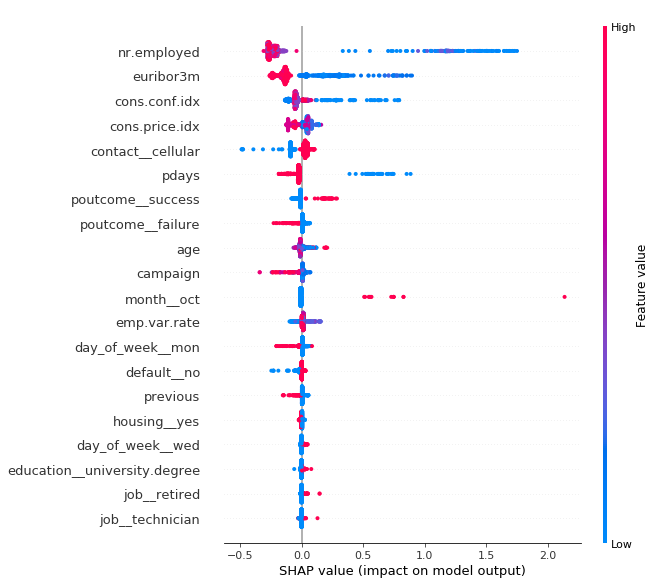

In [44]:
shap.initjs() 
shap.summary_plot(shap_values, features=observations, feature_names=all_features)

That's better than the built-in feature importance on RandomForest because not only we can see what features are important but also how they affect our predictions.

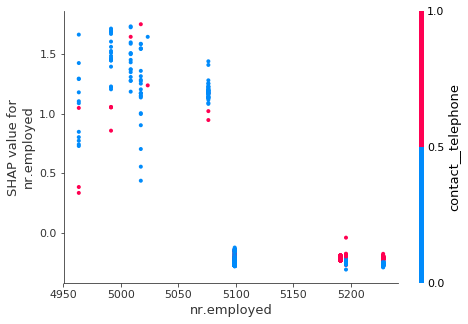

In [45]:
shap.dependence_plot("nr.employed", shap_values, 
                     pd.DataFrame(observations, columns=all_features))

# Intepreting models with non tabular data

The tools we have seen above also work with text data and images. There are plenty of examples available online for text-data. Here we will just demonstrate how to use `Lime` to explain an image classifier.

## Interpreting image classifiers

Lime can also be used to explain decisions made for image classification. 

In this example we will use the pretrained `InceptionV3` model available with Keras. Lime is quite slow with images, so it's wiser to stick to a "shallow" deep learning model.

In [46]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input, decode_predictions
from keras.preprocessing.image import load_img, img_to_array

Using TensorFlow backend.


Let's create a new instance of InceptionV3

In [47]:
model = InceptionV3(input_shape = (299, 299, 3))

Now we'll load a picture of a pug, we need to make sure we load it at the good size for inception, here 299*299

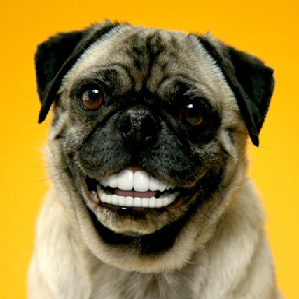

In [48]:
image_raw = load_img("smiling-pug.png", target_size=(299, 299, 3))
image_raw

We need to process the image to get a numpy array compatible with our model. Here we simply loads it to an array, reshape it and use the preprocess_input method provided by Keras that ensures all the preprocessing steps are made for us.

In [49]:
# Convert to numpy array, reshape and preprocess
image = img_to_array(image_raw)
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

Now that our image is ready, generate predictions by using `.predict` as usual.

In [50]:
predictions = model.predict(image)

You can check what labels your predictions correspond to by calling the function `decode_predictions` on your predictions. By default it returns the 5 more likely predictions

In [51]:
decode_predictions(predictions)

[[('n02110958', 'pug', 0.9019966),
  ('n02108422', 'bull_mastiff', 0.0032650335),
  ('n02091467', 'Norwegian_elkhound', 0.0021175968),
  ('n02112706', 'Brabancon_griffon', 0.0018615616),
  ('n02096585', 'Boston_bull', 0.0011981823)]]

Great, we predicted a pug with a probability of 90%, that's promising!

Remember that LIME needs the indices of the class we are interested in. Execute the cell bellow to get the indices corresponding to the 5 most probably classes we predicted above. Those indices correspond to the classes used in the ImageNet dataset that was used to train our model.

In [52]:
model.predict(image).argsort()[0, -5:][::-1]

array([254, 243, 174, 262, 195])

Here the pug corresponds to index 254, the bull_mastiff to index 243, etc..

Let's get started. First import the `LimeImageExplainer` and instantiate a new explainer

In [53]:
from lime.lime_image import LimeImageExplainer

In [54]:
explainer = LimeImageExplainer()

The explainer is the same as before, we call `explain_instance` to generate a new explanation. We need to provide:
- our observation: here the first row of our numpy matrix (that has only one row since we only have one image)
- our predict function, we can simply use the one from our model here
- `top_labels` the number of classes to explain. Here our model generate probabilities for more than a 1000 classes (and we looked at the five first). We do not want LIME to generate local models to explain each of those classes. As lime is pretty slow with images, let's only ask for the explanation to our two main classes, pug and bull_mastiff
- `num_samples`: the number of new datapoints to create to fit a linear model, let's set it to 1000

*WARNING*: that will be slow. 

In [55]:
explanation = explainer.explain_instance(image[0], model.predict, 
                                         top_labels=2, num_samples=500,
                                         random_seed=100)

100% |########################################################################|


In [56]:
from skimage.segmentation import mark_boundaries
from matplotlib import pyplot as plt

First let's check the explanation for the predicted class `pug`. That corresponds to label 254 in the ImageNet classes. We need to use the method `get_image_and_mask` on our explanation object with the following parameters:
- index of the class to explain. We'll start with the index of the main class predicted, that was 254
- positive_only: in order to show the part of the image that contribute positively to this class being selected
- num_features: number of superpixels to use. LIME breaks down our image into a set of superpixels, each containing several pixels. Those superpixels are equivalent to `features` in tabular data.
- hide_rest: to hide the rest of the image

That returns a new image and a mask as numpy arrays. You can then use `mark_boundaries` to show the image together with the mask.

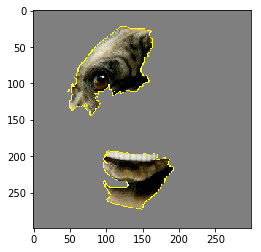

In [57]:
temp, mask = explanation.get_image_and_mask(254, positive_only=True, num_features=5, hide_rest=True)
# plot image and mask together
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

What feature do you expect to be the most important in that decision? Plot the image with only the main feature (`num_features=1`)

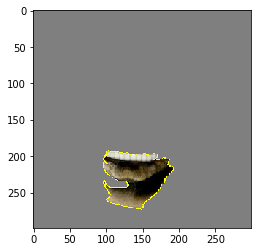

In [58]:
temp, mask = explanation.get_image_and_mask(254, positive_only=True, num_features=1, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

The second class predicted by our model was a bull_mastiff (label 243), set `positive_only=False` in order to see what features contributed positively and negatively to that decision. What do you see?

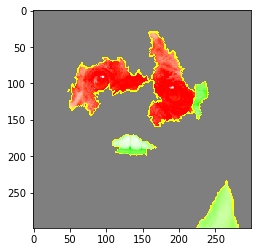

In [60]:
temp, mask = explanation.get_image_and_mask(243, positive_only=False, num_features=8, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Great, now you can try to change the number of features you're looking at and deactivate `positive_only` in order to see features that contribute negatively to the class. You can also look at other classes or try other pictures.